# Import libraries

In [95]:
#COMMON
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import datetime
import http.client
import json
import altair as alt
import altair_viewer
import os
from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

#ML
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from keras import optimizers

# Create extraction function

In [14]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
	plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

	for (x,y,w,h) in plate_rect:
		#a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning #Check this later!
		#plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
		plate = plate_img[y:y+h, x:x+w, :] #don't need the parameter tuning stuff
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
	return plate_img, plate # returning the processed image.

# Apply extraction function

In [15]:
dk_test_img = cv2.imread(r"C:\Users\Peter\Documents\GitHub\car-license-plate-recognition-clean\car-pictures\AJ13870_back.jpg")
plate_img_out, plate_out = extract_plate(dk_test_img)

#cv2.imshow("somethingsomethingdkimg", plate_img_out)
#cv2.waitKey(0) 
#cv2.imshow("somethingsomethingdkimg", plate_out)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Match contours to license plate

In [16]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

# Find characters function

In [17]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

# Apply characters function and see output

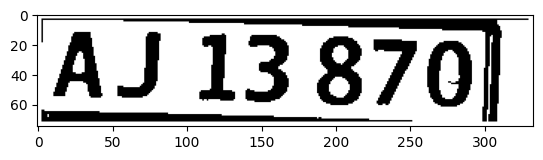

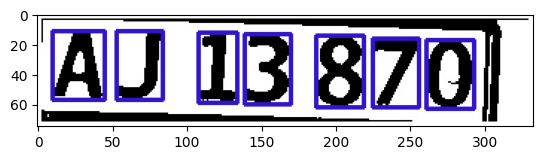

In [18]:
char = segment_characters(plate_out)

# CNN

## Create fit parameters

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Model

In [20]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

c:\Users\Peter\Documents\GitHub\car-license-plate-recognition-clean\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [97]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        55328     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 36)                4644      
                                                        

## A custom training callback

In [21]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.992):
      self.model.stop_training = True

## Create logs

In [22]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Model training

In [23]:
#CAREFUL THIS IS A LARGE PROCESS
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model_history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80)

#, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 8s 9ms/step - loss: 3.5178 - accuracy: 0.0775 - val_loss: 3.3745 - val_accuracy: 0.1991
Epoch 2/80
864/864 [==============================] - 6s 7ms/step - loss: 3.2075 - accuracy: 0.1910
Epoch 3/80
864/864 [==============================] - 6s 8ms/step - loss: 2.6909 - accuracy: 0.3310
Epoch 4/80
864/864 [==============================] - 7s 8ms/step - loss: 2.1987 - accuracy: 0.4502
Epoch 5/80
864/864 [==============================] - 6s 7ms/step - loss: 1.7581 - accuracy: 0.5451
Epoch 6/80
864/864 [==============================] - 7s 8ms/step - loss: 1.4999 - accuracy: 0.5833
Epoch 7/80
864/864 [==============================] - 7s 8ms/step - loss: 1.3693 - accuracy: 0.6227
Epoch 8/80
864/864 [==============================] - 7s 8ms/step - loss: 1.1436 - accuracy: 0.6829
Epoch 9/80
864/864 [==============================] - 6s 7ms/step - loss: 1.0624 - accuracy: 0.6933
Epoch 10/80
864/864 [==============================] - 7s 

## Tensorboard

In [ ]:
#!kill 6360
%load_ext tensorboard
%tensorboard --logdir logs/fit

## Evaluation: Accuracy

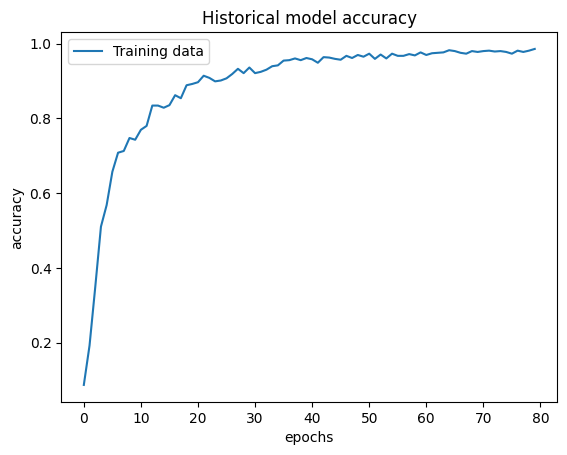

In [103]:
# Visualize the accuracy
plt.plot(model_history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Training data'])
plt.title('Historical model accuracy')
plt.show()

## Evaluation: Loss

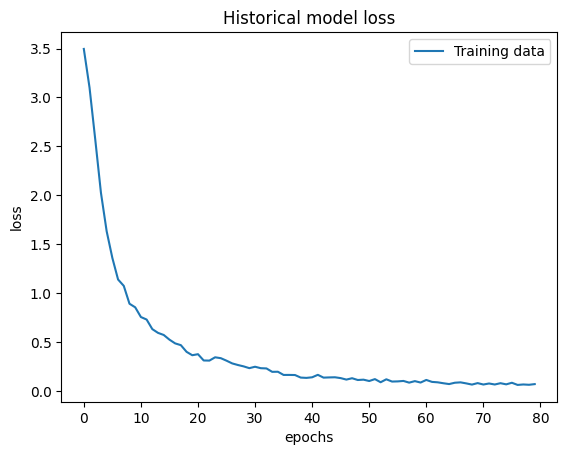

In [102]:
# Visualize the loss
plt.plot(model_history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training data'])
plt.title('Historical model loss')
plt.show()

# Results

## Print plate number

In [25]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(model.predict(img)[0]) #predicting the class np.argmax(model.predict(x_test), axis=-1)     classes_ = np.argmax(y_, axis = 1)
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

final_plate = show_results()
print(final_plate)

1/1 [==============================] - 0s 16ms/step
AJ13870


## Show prediction

1/1 [==============================] - 0s 15ms/step


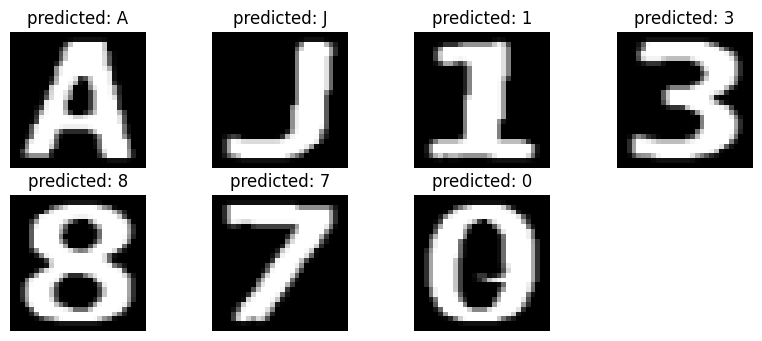

In [26]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

# API

## Create input plate from results

In [27]:
final_plate #Create variable from model
link = "/vehicles?registration_number={}".format(final_plate)
print (link)

/vehicles?registration_number=AJ13870


## API-script

In [28]:
conn = http.client.HTTPSConnection("v1.motorapi.dk")
payload = ''
headers = {
  'X-AUTH-TOKEN': 'gq59xnw6jombh3vpiuvv0lzfh8h7df36'
}
conn.request("GET", link , payload, headers) #We add the link to automate the process of connecting the car plate number with the API
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

[
    {
        "registration_number": "AJ13870",
        "status": "Registreret",
        "status_date": "2013-10-07T10:33:46.000+02:00",
        "type": "Personbil",
        "use": "Privat personk\u00f8rsel",
        "first_registration": "2013-10-07+02:00",
        "vin": "WDD2042021G129692",
        "own_weight": null,
        "cerb_weight": 1655,
        "total_weight": 2195,
        "axels": 2,
        "pulling_axels": 1,
        "seats": 5,
        "coupling": false,
        "trailer_maxweight_nobrakes": 750,
        "trailer_maxweight_withbrakes": 1800,
        "doors": 4,
        "make": "MERCEDES-BENZ",
        "model": "C-Klasse",
        "variant": "220 CDI BlueEFFICIENCY T",
        "model_type": "204 K",
        "model_year": 2013,
        "color": "Gr\u00e5",
        "chassis_type": "Stationcar",
        "engine_cylinders": 4,
        "engine_volume": 2143,
        "engine_power": 125,
        "fuel_type": "Diesel",
        "registration_zipcode": "",
        "vehicle_id

## Transforming API-output to JSON

In [29]:
my_json = data.decode('utf8').replace("'", '"')
print(my_json)
print('- ' * 20)

# Load the JSON to a Python list & dump it back out as formatted JSON
data = json.loads(my_json)
s = json.dumps(data, indent=4, sort_keys=True)

[
    {
        "registration_number": "AJ13870",
        "status": "Registreret",
        "status_date": "2013-10-07T10:33:46.000+02:00",
        "type": "Personbil",
        "use": "Privat personk\u00f8rsel",
        "first_registration": "2013-10-07+02:00",
        "vin": "WDD2042021G129692",
        "own_weight": null,
        "cerb_weight": 1655,
        "total_weight": 2195,
        "axels": 2,
        "pulling_axels": 1,
        "seats": 5,
        "coupling": false,
        "trailer_maxweight_nobrakes": 750,
        "trailer_maxweight_withbrakes": 1800,
        "doors": 4,
        "make": "MERCEDES-BENZ",
        "model": "C-Klasse",
        "variant": "220 CDI BlueEFFICIENCY T",
        "model_type": "204 K",
        "model_year": 2013,
        "color": "Gr\u00e5",
        "chassis_type": "Stationcar",
        "engine_cylinders": 4,
        "engine_volume": 2143,
        "engine_power": 125,
        "fuel_type": "Diesel",
        "registration_zipcode": "",
        "vehicle_id

## Creating it as dictionary

In [30]:
d1=dict(enumerate(data))

## Returning car type

In [31]:
car_type = (f"{(data[0]['make'])} {(data[0]['model'])} {(data[0]['first_registration'])}")

## Car year

In [32]:
car_year = data[0]['first_registration']
car_year2 = car_year[:4]
car_year = car_year2

## Final car type for database

In [33]:
car_type = (f"{(data[0]['make'])} {(data[0]['model'])} {car_year}")
car_type = car_type.lower()
print(car_type)

mercedes-benz c-klasse 2013


# Dataset/database

## Load the dataset

In [2]:
devkit_path = 'car_github/car_devkit/devkit'
cars_path = 'car_github/cars_main'
main_path = 'car_github'

devkit_path

'car_github/car_devkit/devkit'

In [4]:
cars_meta = loadmat('devkit/cars_meta.mat')
cars_annos = loadmat('devkit/cars_train_annos.mat')

## Creating labels

In [5]:
labels = [column for column in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


Checking how many classes are in the dataset

In [6]:
len(labels)

196

How is df structured?

In [7]:
cars_annos['annotations']

array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
        (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
        (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
        ...,
        (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
        (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9')),
        (array([[20]], dtype=uint8

## Creating a df

In [8]:
annotations = cars_annos['annotations']
annotations = np.transpose(annotations)

fnames = []
bboxes = []

for annotation in annotations:
    fname = annotation[0][5][0]
    car_class = annotation[0][4][0]
    bboxes.append((fname, int(list(car_class)[0])))
    
    
df = pd.DataFrame(bboxes, columns = ['fnames','car_class'])

df

,fnames,car_class
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106
...,...,...
8139,08140.jpg,78
8140,08141.jpg,196
8141,08142.jpg,163
8142,08143.jpg,112


Merging labels

In [9]:
df = df.merge(labels, left_on='car_class', right_index=True)
df = df.sort_index() 
df

,fnames,car_class,labels
0,00001.jpg,14,Audi R8 Coupe 2012
1,00002.jpg,3,Acura TL Type-S 2008
2,00003.jpg,91,Dodge Magnum Wagon 2008
3,00004.jpg,134,Hyundai Elantra Sedan 2007
4,00005.jpg,106,Ford Mustang Convertible 2007
...,...,...,...
8138,08139.jpg,188,Toyota 4Runner SUV 2012
8139,08140.jpg,78,Chrysler 300 SRT-8 2010
8141,08142.jpg,163,Mercedes-Benz E-Class Sedan 2012
8142,08143.jpg,112,Ford F-150 Regular Cab 2012


## DF Stringency

As the functions are case sensitive, and the API may return results with a different upper or lower case, we've decided to change the labels column to only contain lower case letters, which is the same in the API data

Apart from this, we have seperated the car classes into 4 new columns, namely: brand, model, type and year. This is done as it will be easier to deal with the individual parts when analysing the data. 

In [10]:
df['labels'] = df['labels'].str.lower()
df['labels_noyear'] = df['labels'].str.split().str[0:-1].apply(lambda x: ' '.join(map(str, x)))
df['brand'] = df['labels'].str.split().str[0]
df['model'] = df['labels'].str.split().str[1:-2].apply(lambda x: ' '.join(map(str, x)))
df['type'] = df['labels'].str.split().str[-2]
df['year'] = df['labels'].str.split().str[-1]
df["labels_notype"] = df['brand'] +" "+ df["model"] + " " + df['year']
df

,fnames,car_class,labels,labels_noyear,brand,model,type,year,labels_notype
0,00001.jpg,14,audi r8 coupe 2012,audi r8 coupe,audi,r8,coupe,2012,audi r8 2012
1,00002.jpg,3,acura tl type-s 2008,acura tl type-s,acura,tl,type-s,2008,acura tl 2008
2,00003.jpg,91,dodge magnum wagon 2008,dodge magnum wagon,dodge,magnum,wagon,2008,dodge magnum 2008
3,00004.jpg,134,hyundai elantra sedan 2007,hyundai elantra sedan,hyundai,elantra,sedan,2007,hyundai elantra 2007
4,00005.jpg,106,ford mustang convertible 2007,ford mustang convertible,ford,mustang,convertible,2007,ford mustang 2007
...,...,...,...,...,...,...,...,...,...
8138,08139.jpg,188,toyota 4runner suv 2012,toyota 4runner suv,toyota,4runner,suv,2012,toyota 4runner 2012
8139,08140.jpg,78,chrysler 300 srt-8 2010,chrysler 300 srt-8,chrysler,300,srt-8,2010,chrysler 300 2010
8141,08142.jpg,163,mercedes-benz e-class sedan 2012,mercedes-benz e-class sedan,mercedes-benz,e-class,sedan,2012,mercedes-benz e-class 2012
8142,08143.jpg,112,ford f-150 regular cab 2012,ford f-150 regular cab,ford,f-150 regular,cab,2012,ford f-150 regular 2012


## DF EDA

### Null values

In [41]:
df.isnull().sum()

fnames           0
bbox_x1          0
bbox_x2          0
bbox_y1          0
bbox_y2          0
car_class        0
labels           0
labels_noyear    0
brand            0
model            0
type             0
year             0
labels_notype    0
dtype: int64

### DF Info

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8104 entries, 0 to 8143
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fnames         8104 non-null   object
 1   bbox_x1        8104 non-null   uint16
 2   bbox_x2        8104 non-null   uint16
 3   bbox_y1        8104 non-null   uint16
 4   bbox_y2        8104 non-null   uint16
 5   car_class      8104 non-null   int64 
 6   labels         8104 non-null   object
 7   labels_noyear  8104 non-null   object
 8   brand          8104 non-null   object
 9   model          8104 non-null   object
 10  type           8104 non-null   object
 11  year           8104 non-null   object
 12  labels_notype  8104 non-null   object
dtypes: int64(1), object(8), uint16(4)
memory usage: 696.4+ KB


### Frequency labels - how many of difference car classes are there?

In [11]:
freq_labels = df.groupby('labels').count()[['car_class']]
freq_labels = freq_labels.rename(columns={'car_class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()

,count
labels,
gmc yukon hybrid suv 2012,68
chrysler crossfire convertible 2008,49
nissan leaf hatchback 2012,48
mercedes-benz c-class sedan 2012,48
chevrolet corvette ron fellows edition z06 2007,47


### Average amount of pictures

In [12]:
freq_labels['count'].mean()

41.55897435897436

### 50 most represented cars in DF

In [13]:
freq_labels = freq_labels.reset_index()
alt.Chart(freq_labels.head(30)).mark_bar().encode(
    x=alt.X('count', axis=alt.Axis(title='Count')),
    y=alt.Y('labels', axis=alt.Axis(title='Model'),sort=(alt.EncodingSortField(field='labels', op='count', order='ascending'))),
    tooltip = 'count',
).interactive().properties(
    width=600,
    height=300
)

c:\Users\Peter\Documents\GitHub\car-license-plate-recognition-clean\.venv\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Here we can see the whole data set, and as we can see that the car model with the fewest amount of pictures still has 24 entries.

In [14]:
alt.Chart(freq_labels.tail(30)).mark_bar().encode(
    x=alt.X('count', axis=alt.Axis(title='Count')),
    y=alt.Y('labels', axis=alt.Axis(title='Model'),sort=(alt.EncodingSortField(field='labels', op='count', order='ascending'))),
    tooltip = 'count',
).interactive().properties(
    width=600,
    height=300
)

alt.Chart(...)

### Model years in df

In [15]:
freq_labels_year = df.groupby('year').count()[['labels']]
freq_labels_year = freq_labels_year.rename(columns={'labels': 'count'})
freq_labels_year = freq_labels_year.sort_values(by='count', ascending=False)
freq_labels_year = freq_labels_year.reset_index()
freq_labels_year

,year,count
0,2012,4856
1,2007,1038
2,2009,542
3,2010,433
4,2011,312
5,2008,288
6,1994,128
7,1993,126
8,1998,86
9,2001,77


In [16]:
alt.Chart(freq_labels_year).mark_bar().encode(
    x=alt.X('year', axis=alt.Axis(title='Year'),sort=(alt.EncodingSortField(field='labels', op='count', order='ascending'))),
    y=alt.Y('count', axis=alt.Axis(title='Count'),),
    tooltip = 'count',
).interactive().properties(
    width=600,
    height=300
)

c:\Users\Peter\Documents\GitHub\car-license-plate-recognition-clean\.venv\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

### Car brand distribution

In [17]:
freq_labels_brand = df.groupby('brand').count()[['labels']]
freq_labels_brand = freq_labels_brand.rename(columns={'labels': 'count'})
freq_labels_brand = freq_labels_brand.sort_values(by='count', ascending=False)
freq_labels_brand = freq_labels_brand.reset_index()
freq_labels_brand

,brand,count
0,chevrolet,906
1,dodge,633
2,audi,587
3,bmw,530
4,ford,522
5,hyundai,435
6,mercedes-benz,264
7,chrysler,259
8,acura,248
9,gmc,241


In [18]:
alt.Chart(freq_labels_brand).mark_bar().encode(
    x=alt.X('brand', axis=alt.Axis(title='Brand'),sort=(alt.EncodingSortField(field='labels', op='count', order='ascending'))),
    y=alt.Y('count', axis=alt.Axis(title='Count'),),
    tooltip = 'count',
).interactive().properties(
    width=600,
    height=300
)

c:\Users\Peter\Documents\GitHub\car-license-plate-recognition-clean\.venv\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

### Unique labels

In [19]:
df_unique = df.copy()
df_unique = df_unique.drop_duplicates(subset=['car_class']).reset_index()
df_unique = df_unique.drop('index',axis=1)
df_unique

,fnames,car_class,labels,labels_noyear,brand,model,type,year,labels_notype
0,00001.jpg,14,audi r8 coupe 2012,audi r8 coupe,audi,r8,coupe,2012,audi r8 2012
1,00002.jpg,3,acura tl type-s 2008,acura tl type-s,acura,tl,type-s,2008,acura tl 2008
2,00003.jpg,91,dodge magnum wagon 2008,dodge magnum wagon,dodge,magnum,wagon,2008,dodge magnum 2008
3,00004.jpg,134,hyundai elantra sedan 2007,hyundai elantra sedan,hyundai,elantra,sedan,2007,hyundai elantra 2007
4,00005.jpg,106,ford mustang convertible 2007,ford mustang convertible,ford,mustang,convertible,2007,ford mustang 2007
...,...,...,...,...,...,...,...,...,...
190,00670.jpg,2,acura tl sedan 2012,acura tl sedan,acura,tl,sedan,2012,acura tl 2012
191,00678.jpg,27,bmw 1 series coupe 2012,bmw 1 series coupe,bmw,1 series,coupe,2012,bmw 1 series 2012
192,00705.jpg,95,dodge charger sedan 2012,dodge charger sedan,dodge,charger,sedan,2012,dodge charger 2012
193,00792.jpg,35,bmw m6 convertible 2010,bmw m6 convertible,bmw,m6,convertible,2010,bmw m6 2010


Below we can see that there are 195 unique labels contained in the training data set, this means that there is one of the labels that does not have a picture in this data set.

In [52]:
df_unique['labels'].count()

195

In [53]:
df_unique['labels_noyear'].count()

195

In [20]:
df = df.groupby('car_class').head(4)
df

,fnames,car_class,labels,labels_noyear,brand,model,type,year,labels_notype
0,00001.jpg,14,audi r8 coupe 2012,audi r8 coupe,audi,r8,coupe,2012,audi r8 2012
1,00002.jpg,3,acura tl type-s 2008,acura tl type-s,acura,tl,type-s,2008,acura tl 2008
2,00003.jpg,91,dodge magnum wagon 2008,dodge magnum wagon,dodge,magnum,wagon,2008,dodge magnum 2008
3,00004.jpg,134,hyundai elantra sedan 2007,hyundai elantra sedan,hyundai,elantra,sedan,2007,hyundai elantra 2007
4,00005.jpg,106,ford mustang convertible 2007,ford mustang convertible,ford,mustang,convertible,2007,ford mustang 2007
...,...,...,...,...,...,...,...,...,...
1674,01675.jpg,35,bmw m6 convertible 2010,bmw m6 convertible,bmw,m6,convertible,2010,bmw m6 2010
1678,01679.jpg,64,chevrolet avalanche crew cab 2012,chevrolet avalanche crew cab,chevrolet,avalanche crew,cab,2012,chevrolet avalanche crew 2012
1704,01705.jpg,3,acura tl type-s 2008,acura tl type-s,acura,tl,type-s,2008,acura tl 2008
1824,01825.jpg,35,bmw m6 convertible 2010,bmw m6 convertible,bmw,m6,convertible,2010,bmw m6 2010


## Google search

In [21]:
def google_search(url):
  url = url.replace(' ', '+')
  link = "https://www.google.com/search?tbm=isch&q=" + url
  return link

In [22]:
google_search(car_type)

NameError: name 'car_type' is not defined

In [71]:
#cars_path = Path(r'https://drive.google.com/drive/folders/1Mu8UXk_k7pnIALvTIquAcMKrURDPL8xF')
#main_path = Path(r'https://drive.google.com/drive/folders/1paR6lUCkXaF5kHyLSp_YD4WXcM8ULFQS')

In [23]:
# Def get assets

def get_assets(car, i=0):
    print("You've searched for: " + car.title())
    search = df.index[df['labels']==car].tolist() #find all cars that matches the string containing car information
    os.chdir('car_github')
    if not search:
      # if statement to check if the car model is in the database or not, if not return image not available.
        print('We do not have any images of this car in our database, here is a Google link: ' + google_search(car))
        title = 'No image in our database'
        image = Image.open('cars_main/no_image.jpg')
        
    else:
        max_index = len(search)-1
        if i > max_index:
          search = search[max_index]
        else: 
          search = search[i]
        image = Image.open('cars_main/' + df['fnames'][search])
        title = df['labels'][search].title()
    os.chdir('..')
    return (image, title)

In [24]:
def display_image(car, i=0):
  #function displays the car found in the get_assets function as well as add the rectangle around the car and name of the car, lastly it makes sure to change the directory back to the main path again.
    image, title = get_assets(car, i)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

In [26]:
def find_assets(search, i=0):
  distinct_models = df_unique[df_unique['labels'].str.contains(search)]
  distinct_models = distinct_models['labels'].str.title()
  distinct_models = distinct_models.rename('Car Models')
  found_models = df[df['labels'].str.contains(search)]
  found_models = found_models['labels'].str.title()
  found_models = found_models.rename('Car Models')
  return distinct_models, found_models

In [27]:

def search_function(search, i=0):
  distinct_models, found_models = find_assets(search)
  print("{}{}{}{}{}".format('There were ', distinct_models.count(), ' unique models, and a total of ', found_models.count(), ' results'))
  if i == 0:
    print(distinct_models.reset_index().drop('index',axis=1))
  else:
    print(found_models.reset_index().drop('index',axis=1))

  

In [76]:
display_image(car_type)

You've searched for: Mercedes-Benz C-Klasse 2013


OSError: [WinError 123] Syntaksen i filnavnet, mappen eller diskenhedsnavnet er forkert: 'https:\\drive.google.com\\drive\\folders\\1Mu8UXk_k7pnIALvTIquAcMKrURDPL8xF'